In [1]:
from Config.config import CONFIG
CONFIG = CONFIG("Wikipedia")

In [2]:
from DyGLib.models.GraphMixer import GraphMixer
from DyGLib.models.TGAT import TGAT
from DyGLib.models.TCL import TCL
from DyGLib.models.CAWN import CAWN
from DyGLib.models.DyGFormer import DyGFormer
from DyGLib.models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts

from DyGLib.models.modules import TGNN, NeuralNetworkSrcDst, BatchSubgraphs
from DyGLib.utils.DataLoader import get_link_prediction_data
from DyGLib.utils.utils import get_neighbor_sampler, NegativeEdgeSampler

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import random

import graphviz
from IPython.display import SVG
import time

# Initialization

In [3]:
trained_model_path = CONFIG.model.trained_model_path
edge_feat_path = CONFIG.data.folder + CONFIG.data.edge_feat_file
node_feat_path = CONFIG.data.folder + CONFIG.data.node_feat_file
index_path = CONFIG.data.folder + CONFIG.data.index_file
feature_names_path = CONFIG.data.folder + CONFIG.data.feature_names_file

In [4]:
# get data for training, validation and testing
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data = \
    get_link_prediction_data(val_ratio=0.1, test_ratio=0.1, node_dim=CONFIG.model.node_dim)

# initialize validation and test neighbor sampler to retrieve temporal graph
full_neighbor_sampler = get_neighbor_sampler(data=full_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)
train_neighbor_sampler = get_neighbor_sampler(data=train_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)

# create model
if CONFIG.model.model_name == 'TGAT':
    dynamic_backbone = TGAT(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name in ['JODIE', 'DyRep', 'TGN']:
    # four floats that represent the mean and standard deviation of source and destination node time shifts in the training data, which is used for JODIE
    src_node_mean_time_shift, src_node_std_time_shift, dst_node_mean_time_shift_dst, dst_node_std_time_shift = \
        compute_src_dst_node_time_shifts(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)
    dynamic_backbone = MemoryModel(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, model_name=CONFIG.model.model_name, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                                    dropout=CONFIG.model.dropout, src_node_mean_time_shift=src_node_mean_time_shift, src_node_std_time_shift=src_node_std_time_shift,
                                    dst_node_mean_time_shift_dst=dst_node_mean_time_shift_dst, dst_node_std_time_shift=dst_node_std_time_shift, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'CAWN':
    dynamic_backbone = CAWN(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, position_feat_dim=CONFIG.model.position_feat_dim, walk_length=CONFIG.model.walk_length,
                            num_walk_heads=CONFIG.model.num_walk_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'TCL':
    dynamic_backbone = TCL(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                            num_depths=CONFIG.model.num_neighbors + 1, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'GraphMixer':
    dynamic_backbone = GraphMixer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_tokens=CONFIG.model.num_neighbors, num_layers=CONFIG.model.num_layers, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'DyGFormer':
    dynamic_backbone = DyGFormer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, channel_embedding_dim=CONFIG.model.channel_embedding_dim, patch_size=CONFIG.model.patch_size,
                                    num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout,
                                    max_input_sequence_length=CONFIG.model.max_input_sequence_length, device=CONFIG.model.device)
else:
    raise ValueError(f"Wrong value for model_name {CONFIG.model.model_name}!")

regressor = NeuralNetworkSrcDst(input_dim=node_raw_features.shape[1], num_layers=CONFIG.model.num_reg_layers, hidden_dim=CONFIG.model.hidden_reg_layers_dim)
model = TGNN(dynamic_backbone, regressor)

The dataset has 157474 interactions, involving 9227 different nodes
The training dataset has 88991 interactions, involving 6323 different nodes
The validation dataset has 15747 interactions, involving 2841 different nodes
The test dataset has 15748 interactions, involving 2865 different nodes
The new node validation dataset has 7852 interactions, involving 1905 different nodes
The new node test dataset has 8384 interactions, involving 1981 different nodes
922 nodes were used for the inductive testing, i.e. are never seen during training


In [5]:
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(CONFIG.model.device)
model.eval()

TGNN(
  (backbone): TGAT(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (temporal_conv_layers): ModuleList(
      (0-1): 2 x MultiHeadAttention(
        (query_projection): Linear(in_features=272, out_features=272, bias=False)
        (key_projection): Linear(in_features=444, out_features=272, bias=False)
        (value_projection): Linear(in_features=444, out_features=272, bias=False)
        (layer_norm): LayerNorm((272,), eps=1e-05, elementwise_affine=True)
        (residual_fc): Linear(in_features=272, out_features=272, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (projectors): ModuleList(
      (0-1): 2 x Linear(in_features=444, out_features=172, bias=True)
    )
  )
  (model): NeuralNetworkSrcDst(
    (model): Sequential(
      (0): Linear(in_features=344, out_features=172, bias=True)
      (1): ReLU()
      (2): Linear(in_features=172, out_features=1, bias=True)
    )
  )
)

## Select edges

In [6]:
num_samples = 200

In [7]:
def get_edge_by_id(link_index):
    src, dst, time_stamp, edge_id, true_value = full_data.src_node_ids[link_index], full_data.dst_node_ids[link_index], full_data.node_interact_times[link_index], full_data.edge_ids[link_index], 1 # type: ignore
    return src, dst, time_stamp, edge_id, true_value

In [8]:
random.seed(2025)

sampled_edge_ids = random.sample((np.where((~np.isnan(full_data.labels)) & (~np.isin(full_data.edge_ids, train_data.edge_ids)))[0]).tolist(), num_samples)

edge_info_array = np.array([list(get_edge_by_id(i)) for i in sampled_edge_ids])
edge_info = pd.DataFrame(edge_info_array, columns=["Src", "Dst", "Time", "Event", "Target"])

edges = edge_info["Event"].to_numpy(dtype=int)

edge_info["InTrain"] = np.isin(edges, train_data.edge_ids)
edge_info = edge_info.sort_values(by="InTrain").reset_index(drop=True)
edge_info = edge_info[edge_info.InTrain == False]

srcs = edge_info["Src"].to_numpy(dtype=int)
dsts = edge_info["Dst"].to_numpy(dtype=int)
timestamps = edge_info["Time"].to_numpy(dtype="float32")
targets = edge_info["Target"].to_numpy(dtype="float32")

In [9]:
model.eval()

subgraphs_src = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, srcs, timestamps, num_neighbors = CONFIG.model.num_neighbors)
subgraphs_dst = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, dsts, timestamps, num_neighbors = CONFIG.model.num_neighbors)
edge_feat_src = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_src[1])
edge_feat_dst = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_dst[1])

subgraphs_src = BatchSubgraphs(*subgraphs_src, edge_feat_src)
subgraphs_src.to(CONFIG.model.device)
subgraphs_dst = BatchSubgraphs(*subgraphs_dst, edge_feat_dst)
subgraphs_dst.to(CONFIG.model.device)

predicts = model(src_node_ids=srcs,
                dst_node_ids=dsts,
                node_interact_times=timestamps,
                src_subgraphs = subgraphs_src,
                dst_subgraphs = subgraphs_dst,
                time_gap=CONFIG.model.time_gap,
                edges_are_positive=True).squeeze(dim=-1).sigmoid()

edge_info["Prediction"] = predicts.detach().cpu().numpy()
edge_info

,Src,Dst,Time,Event,Target,InTrain,Prediction
0,418.0,8482.0,759893.0,41232.0,1.0,False,0.842400
1,6546.0,9181.0,2387240.0,143688.0,1.0,False,0.999524
2,1258.0,8736.0,2189684.0,132384.0,1.0,False,0.607021
3,286.0,8627.0,2189617.0,132376.0,1.0,False,0.843475
4,64.0,8695.0,1055237.0,59876.0,1.0,False,0.996031
...,...,...,...,...,...,...,...
195,1693.0,8233.0,2305985.0,139280.0,1.0,False,0.997764
196,2295.0,8692.0,2219716.0,133995.0,1.0,False,0.993192
197,4711.0,8657.0,2655586.0,156372.0,1.0,False,0.964953
198,738.0,8426.0,1258777.0,72035.0,1.0,False,0.738178


In [10]:
timings = []

# Shapley values - Event level

In [11]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerEvents
import shap

c:\Users\LMS\Documents\Masterarbeit\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
explainer = ShapleyExplainerEvents(model, full_neighbor_sampler, full_data, edge_raw_features)

In [13]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNEvent", "Init"]]))

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_shapley_edge, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNEvent"), np.full(exec_times.shape, "Explain")]))
result_shapley_edge["Explainer"] = "Shapley4TGNNEvent"
result_shapley_edge

100%|██████████| 200/200 [07:17<00:00,  2.19s/it]


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.892,1.000,0.912,0.000,-0.148,0.503,-0.088,0.000,Zero,Shapley4TGNNEvent
1,0.892,1.000,0.912,0.001,-0.148,0.503,-0.088,0.000,Zero,Shapley4TGNNEvent
2,0.892,1.000,0.912,0.001,-0.148,0.503,-0.088,0.000,Zero,Shapley4TGNNEvent
3,0.892,1.000,0.912,0.002,-0.148,0.503,-0.088,0.000,Zero,Shapley4TGNNEvent
4,0.892,1.000,0.904,0.002,-0.150,0.437,-0.096,0.000,Zero,Shapley4TGNNEvent
...,...,...,...,...,...,...,...,...,...,...
47,0.892,1.000,0.886,0.998,-0.009,-0.018,-0.114,0.660,Mean,Shapley4TGNNEvent
48,0.892,1.000,0.887,0.998,-0.008,-0.014,-0.113,0.690,Mean,Shapley4TGNNEvent
49,0.892,1.000,0.887,0.999,-0.008,-0.014,-0.113,0.690,Mean,Shapley4TGNNEvent
50,0.892,1.000,0.887,0.999,-0.008,-0.014,-0.113,0.690,Mean,Shapley4TGNNEvent


In [15]:
explainer = None
torch.cuda.empty_cache()

# Shapley values - Feature level

In [16]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerFeatures
from Explainers.Shapley4TGNN.Plots import waterfall
import shap
from shap import Explanation

In [17]:
explainer = ShapleyExplainerFeatures(model, full_neighbor_sampler, full_data, edge_raw_features, None, shapley_alg="MonteCarlo", top_k=4)

In [18]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNFeature", "Init"]]))

In [19]:
result_shapley_feat, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNFeature"), np.full(exec_times.shape, "Explain")]))
result_shapley_feat["Explainer"] = "Shapley4TGNNFeature"
result_shapley_feat

100%|██████████| 200/200 [11:43:21<00:00, 211.01s/it]  


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.892,1.000,0.985,0.000,-0.102,1.803,-0.015,0.001,Zero,Shapley4TGNNFeature
1,0.892,1.000,0.896,0.002,-0.092,1.244,-0.104,0.000,Zero,Shapley4TGNNFeature
2,0.892,1.000,0.894,0.003,-0.091,1.186,-0.106,0.000,Zero,Shapley4TGNNFeature
3,0.892,1.000,0.895,0.004,-0.090,1.183,-0.105,0.000,Zero,Shapley4TGNNFeature
4,0.892,1.000,0.897,0.005,-0.088,1.204,-0.103,0.000,Zero,Shapley4TGNNFeature
...,...,...,...,...,...,...,...,...,...,...
47,0.892,1.000,0.890,0.995,-0.003,-0.007,-0.110,0.969,Mean,Shapley4TGNNFeature
48,0.892,1.000,0.890,0.996,-0.003,-0.006,-0.110,0.951,Mean,Shapley4TGNNFeature
49,0.892,1.000,0.891,0.997,-0.002,-0.002,-0.109,0.995,Mean,Shapley4TGNNFeature
50,0.892,1.000,0.892,0.998,-0.001,0.001,-0.108,0.998,Mean,Shapley4TGNNFeature


In [20]:
explainer = None
torch.cuda.empty_cache()

# TGNN Explainer

In [21]:
from Explainers.External.tgnnexplainer.Explainer import SubgraphXTExplainer

In [22]:
explainer = SubgraphXTExplainer(model, full_neighbor_sampler, full_data)

In [23]:
timings.append(np.array([[0, "TGNNExplainer", "Init"]]))

In [24]:
result_tgnnexpl, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TGNNExplainer"), np.full(exec_times.shape,"Explain")]))
result_tgnnexpl["Explainer"] = "TGNNExplainer"
result_tgnnexpl

100%|██████████| 200/200 [5:48:52<00:00, 104.66s/it]  


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.892,1.000,0.912,0.000,-0.148,0.503,-0.088,0.000,Zero,TGNNExplainer
1,0.892,1.000,0.912,0.001,-0.148,0.503,-0.088,0.000,Zero,TGNNExplainer
2,0.892,1.000,0.912,0.001,-0.148,0.503,-0.088,0.000,Zero,TGNNExplainer
3,0.892,1.000,0.912,0.002,-0.148,0.503,-0.088,0.000,Zero,TGNNExplainer
4,0.892,1.000,0.912,0.002,-0.148,0.503,-0.088,0.000,Zero,TGNNExplainer
...,...,...,...,...,...,...,...,...,...,...
47,0.892,1.000,0.888,0.998,-0.011,-0.037,-0.112,0.511,Mean,TGNNExplainer
48,0.892,1.000,0.891,0.998,-0.008,-0.024,-0.109,0.749,Mean,TGNNExplainer
49,0.892,1.000,0.891,0.999,-0.008,-0.024,-0.109,0.749,Mean,TGNNExplainer
50,0.892,1.000,0.891,0.999,-0.008,-0.024,-0.109,0.749,Mean,TGNNExplainer


In [25]:
explainer = None
torch.cuda.empty_cache()

# TempME

In [26]:
from Explainers.External.TempME.Explainer import TempMEExplainer
from Explainers.External.TempME.utils.graph import get_walk_finder

In [27]:
preprocessing = True

In [28]:
# Preprocessing
if(preprocessing):
    # Preprocessing train data
    explainer = TempMEExplainer(model, train_neighbor_sampler, train_data)
    walk_finder = get_walk_finder(train_data)
    neg_edge_sampler = NegativeEdgeSampler(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=True)
    # Training
    explainer.initialize(train = True)
    # Preprocessing full data
    explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
    walk_finder = get_walk_finder(full_data)
    neg_edge_sampler = NegativeEdgeSampler(full_data.src_node_ids, full_data.dst_node_ids, full_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=False)

start extracting subgraph


100%|██████████| 88991/88991 [09:15<00:00, 160.27it/s]


done


100%|██████████| 88991/88991 [00:14<00:00, 5990.93it/s] 


num of training instances: 88991
num of batches per epoch: 178


100%|██████████| 178/178 [00:29<00:00,  6.07it/s]


Training Epoch: 0 | Training loss: -19.299471817659526 | Pred loss: -19.0729064619943 | KL loss: -0.45313061941205784 | 


100%|██████████| 178/178 [00:28<00:00,  6.18it/s]


Training Epoch: 1 | Training loss: -19.380396028582968 | Pred loss: -19.152137874217516 | KL loss: -0.456516252809696 | 


100%|██████████| 178/178 [00:28<00:00,  6.18it/s]


Training Epoch: 2 | Training loss: -19.41782309500019 | Pred loss: -19.18956361191996 | KL loss: -0.4565189351861397 | 


100%|██████████| 178/178 [00:28<00:00,  6.17it/s]


Training Epoch: 3 | Training loss: -19.3785321096356 | Pred loss: -19.150272733709784 | KL loss: -0.45651928142885145 | 


100%|██████████| 178/178 [00:28<00:00,  6.18it/s]


Training Epoch: 4 | Training loss: -19.282348782828684 | Pred loss: -19.054089321179337 | KL loss: -0.45651887959978554 | 


100%|██████████| 178/178 [00:28<00:00,  6.17it/s]


Training Epoch: 5 | Training loss: -19.31868364569846 | Pred loss: -19.090423658992467 | KL loss: -0.4565197026796555 | 


100%|██████████| 178/178 [00:28<00:00,  6.16it/s]


Training Epoch: 6 | Training loss: -19.299601415569864 | Pred loss: -19.071342221806557 | KL loss: -0.45651804463247236 | 


100%|██████████| 178/178 [00:29<00:00,  6.11it/s]


Training Epoch: 7 | Training loss: -19.333608187986226 | Pred loss: -19.10534826557288 | KL loss: -0.4565197736694572 | 


100%|██████████| 178/178 [00:28<00:00,  6.16it/s]


Training Epoch: 8 | Training loss: -19.360618194837247 | Pred loss: -19.13235891535041 | KL loss: -0.4565182780281881 | 


100%|██████████| 178/178 [00:29<00:00,  6.13it/s]


Training Epoch: 9 | Training loss: -19.291018400299414 | Pred loss: -19.062759056519926 | KL loss: -0.45651829694763996 | 
start extracting subgraph


100%|██████████| 157474/157474 [17:33<00:00, 149.41it/s]


done


100%|██████████| 157474/157474 [00:33<00:00, 4749.00it/s]


In [29]:
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)

In [30]:
# Interference
start = time.time_ns()
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
explainer.initialize(train = False)
end = time.time_ns()
timings.append(np.array([[end-start, "TempME", "Init"]]))

In [31]:
result_tempme, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TempME"), np.full(exec_times.shape, "Explain")]))
result_tempme["Explainer"] = "TempME"
result_tempme

 18%|█▊        | 36/200 [00:46<03:51,  1.41s/it]

Exception for 67 to 8290 at 120802.0 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 145, in evaluate
    evaluation, _ = evaluator.evaluate(
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 320, in evaluate
    subgraph_src.keep_events(coalitions_per_sparsity, default_values)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1144, in keep_events
    default_features, default_timings = self._get_default_event_array(i, data_per_event)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1113, in _get_default_event_array
    num_features = next(iter(data_per_event.values())).shape[0]
StopIteration



 64%|██████▍   | 128/200 [02:44<01:25,  1.19s/it]

Exception for 4 to 8231 at 4334.0 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 145, in evaluate
    evaluation, _ = evaluator.evaluate(
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 320, in evaluate
    subgraph_src.keep_events(coalitions_per_sparsity, default_values)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1144, in keep_events
    default_features, default_timings = self._get_default_event_array(i, data_per_event)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1113, in _get_default_event_array
    num_features = next(iter(data_per_event.values())).shape[0]
StopIteration



 68%|██████▊   | 135/200 [02:52<01:23,  1.28s/it]

Exception for 411 to 8295 at 900085.0 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 145, in evaluate
    evaluation, _ = evaluator.evaluate(
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 320, in evaluate
    subgraph_src.keep_events(coalitions_per_sparsity, default_values)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1144, in keep_events
    default_features, default_timings = self._get_default_event_array(i, data_per_event)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1113, in _get_default_event_array
    num_features = next(iter(data_per_event.values())).shape[0]
StopIteration



 96%|█████████▌| 191/200 [04:07<00:12,  1.37s/it]

Exception for 4 to 8231 at 3113.0 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 145, in evaluate
    evaluation, _ = evaluator.evaluate(
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 320, in evaluate
    subgraph_src.keep_events(coalitions_per_sparsity, default_values)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1144, in keep_events
    default_features, default_timings = self._get_default_event_array(i, data_per_event)
  File "c:\Users\LMS\Documents\Masterarbeit\DyGLib\utils\utils.py", line 1113, in _get_default_event_array
    num_features = next(iter(data_per_event.values())).shape[0]
StopIteration



100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.916,1.000,0.892,0.000,-0.135,-0.108,-0.108,0.000,Zero,TempME
1,0.916,1.000,0.892,0.001,-0.135,-0.108,-0.108,0.000,Zero,TempME
2,0.916,1.000,0.892,0.001,-0.135,-0.108,-0.108,0.000,Zero,TempME
3,0.916,1.000,0.892,0.002,-0.135,-0.108,-0.108,0.000,Zero,TempME
4,0.916,1.000,0.889,0.002,-0.137,-0.170,-0.111,0.000,Zero,TempME
...,...,...,...,...,...,...,...,...,...,...
47,0.916,1.000,0.917,0.998,-0.002,-0.006,-0.083,0.974,Mean,TempME
48,0.916,1.000,0.917,0.998,-0.002,-0.006,-0.083,0.974,Mean,TempME
49,0.916,1.000,0.917,0.999,-0.002,-0.006,-0.083,0.974,Mean,TempME
50,0.916,1.000,0.917,0.999,-0.002,-0.006,-0.083,0.974,Mean,TempME


In [32]:
explainer = None
torch.cuda.empty_cache()

# Evaluation

In [33]:
from Config.colors import PALLETTE2, PRIMARYCOLOR
import matplotlib.pyplot as plt

In [34]:
df = pd.concat([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat])
df.head()

,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.916,1.000,0.892,0.000,-0.135,-0.108,-0.108,0.000,Zero,TempME
1,0.916,1.000,0.892,0.001,-0.135,-0.108,-0.108,0.000,Zero,TempME
2,0.916,1.000,0.892,0.001,-0.135,-0.108,-0.108,0.000,Zero,TempME
3,0.916,1.000,0.892,0.002,-0.135,-0.108,-0.108,0.000,Zero,TempME
4,0.916,1.000,0.889,0.002,-0.137,-0.170,-0.111,0.000,Zero,TempME


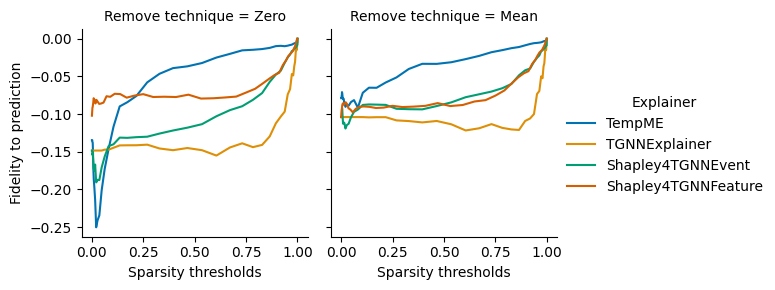

In [35]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_curve.png", bbox_inches='tight')

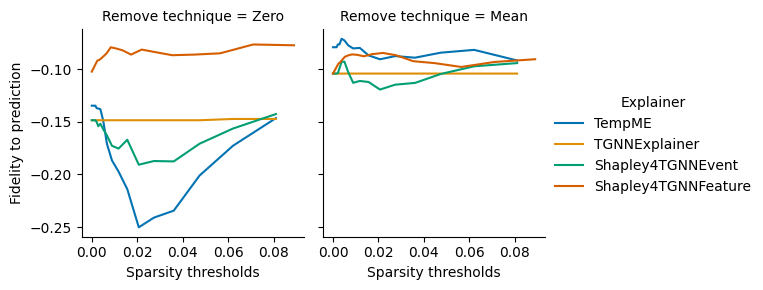

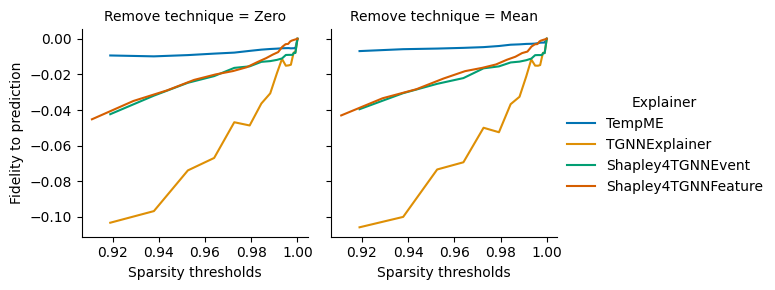

In [36]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_curve_upper_part.png", bbox_inches='tight')
plt.show()

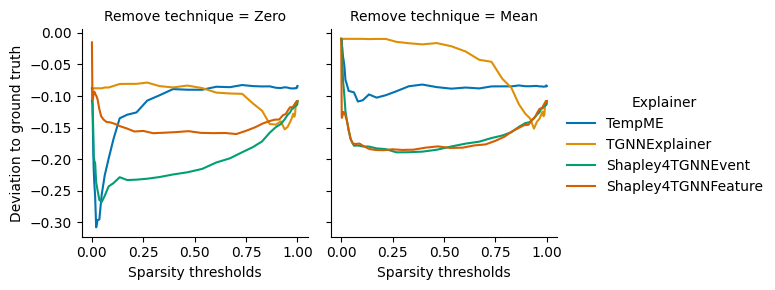

In [37]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Deviation_curve.png", bbox_inches='tight')

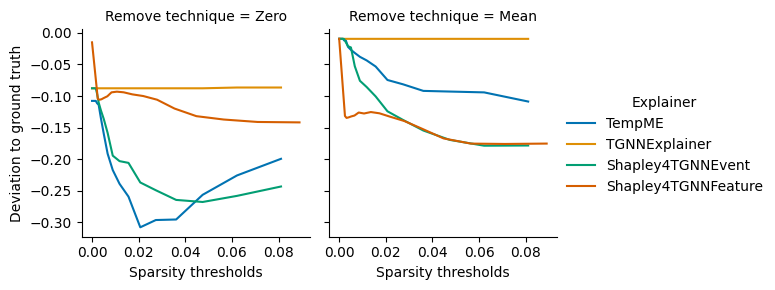

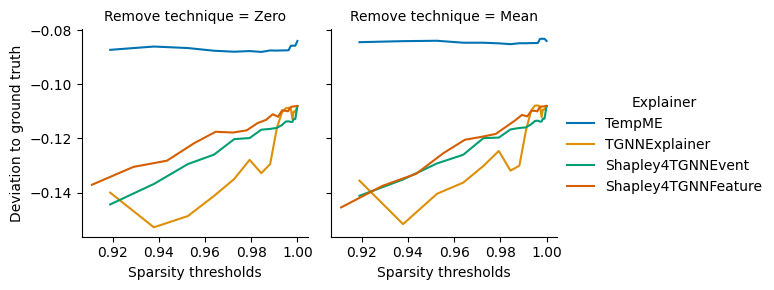

In [38]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Deviation_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Deviation_curve_upper_part.png", bbox_inches='tight')
plt.show()

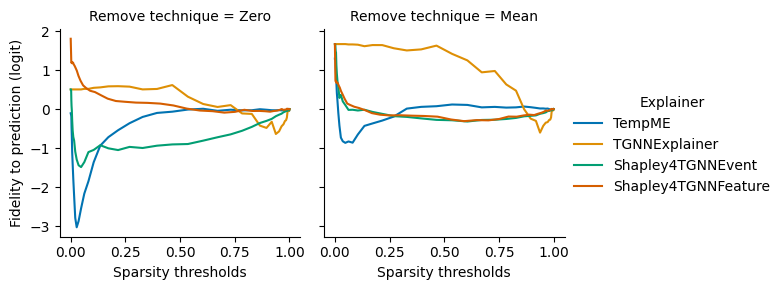

In [39]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_logit_curve.png", bbox_inches='tight')

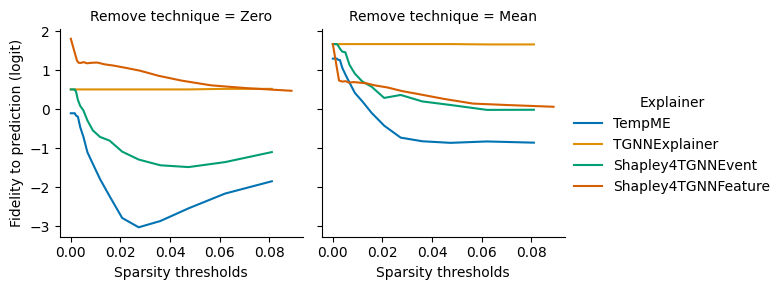

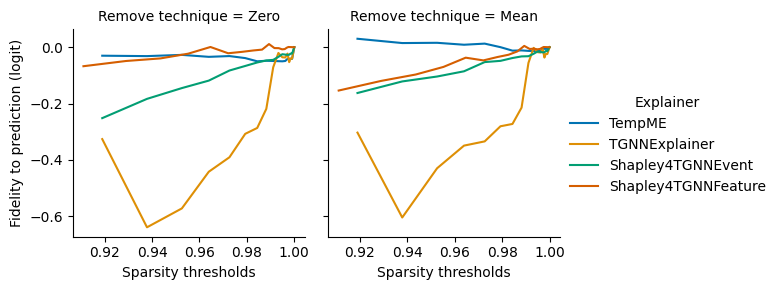

In [40]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_logit_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/Fid_logit_curve_upper_part.png", bbox_inches='tight')
plt.show()

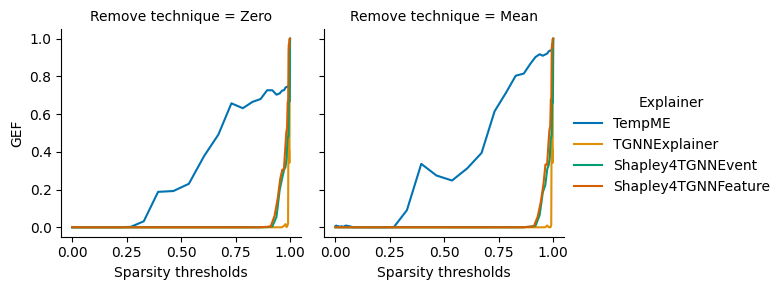

In [41]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/GEF_curve.png", bbox_inches='tight')

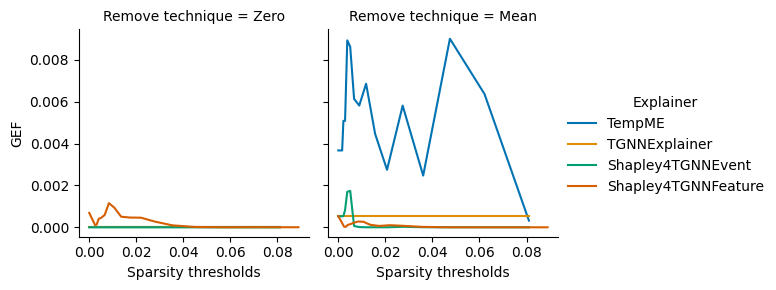

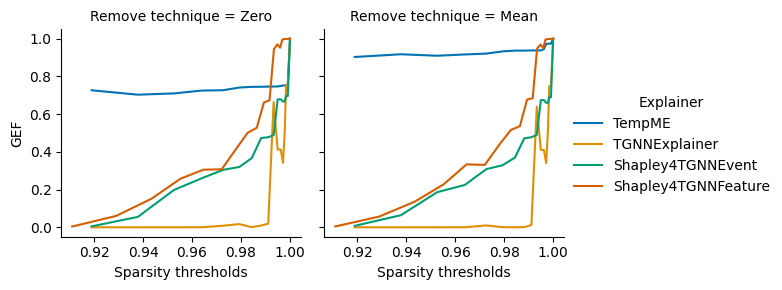

In [42]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/GEF_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Wikipedia/GEF_curve_upper_part.png", bbox_inches='tight')
plt.show()

## AUCs

In [43]:
from Explainers.utils import calc_auc

auc_fid_log_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Zero")
auc_fid_log_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Mean")
auc_fid_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Zero")
auc_fid_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Mean")
auc_dev_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Zero")
auc_dev_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Mean")
auc_gef_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Zero")
auc_gef_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Mean")

print(f"AUC for Fidelity (logit) using Zero: {auc_fid_log_zero}")
print(f"AUC for Fidelity (logit) using Mean: {auc_fid_log_mean}")
print("")
print(f"AUC for Fidelity using Zero: {auc_fid_zero}")
print(f"AUC for Fidelity using Mean: {auc_fid_mean}")
print("")
print(f"AUC for Deviation using Zero: {auc_dev_zero}")
print(f"AUC for Deviation using Mean: {auc_dev_mean}")
print("")
print(f"AUC for GEF: {auc_gef_zero}")
print(f"AUC for GEF: {auc_gef_mean}")

text_zero=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Wikipedia}}}}}} & TGNN Explainer & {round(auc_fid_zero[1],4)} & {round(auc_fid_log_zero[1],4)} & {round(auc_dev_zero[1],4)} & {round(auc_gef_zero[1],4)} \\\\
& TempME & {round(auc_fid_zero[0],4)} & {round(auc_fid_log_zero[0],4)} & {round(auc_dev_zero[0],4)} & {round(auc_gef_zero[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_zero[2],4)} & {round(auc_fid_log_zero[2],4)} & {round(auc_dev_zero[2],4)} & {round(auc_gef_zero[2],4)}\\\\
& Shapley (Feature) & {round(auc_fid_zero[3],4)} & {round(auc_fid_log_zero[3],4)} & {round(auc_dev_zero[3],4)} & {round(auc_gef_zero[3],4)}\\\\
"""

print(text_zero)

text_mean=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Wikipedia}}}}}} & TGNN Explainer & {round(auc_fid_mean[1],4)} & {round(auc_fid_log_mean[1],4)} & {round(auc_dev_mean[1],4)} & {round(auc_gef_mean[1],4)} \\\\
& TempME & {round(auc_fid_mean[0],4)} & {round(auc_fid_log_mean[0],4)} & {round(auc_dev_mean[0],4)} & {round(auc_gef_mean[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_mean[2],4)} & {round(auc_fid_log_mean[2],4)} & {round(auc_dev_mean[2],4)} & {round(auc_gef_mean[2],4)} \\\\
& Shapley (Feature) & {round(auc_fid_mean[3],4)} & {round(auc_fid_log_mean[3],4)} & {round(auc_dev_mean[3],4)} & {round(auc_gef_mean[3],4)} \\\\
"""

print(text_mean)

AUC for Fidelity (logit) using Zero: [np.float64(2.6518634850130693), np.float64(3.2735047020339105), np.float64(2.254098127074511), np.float64(3.1668382979688245)]
AUC for Fidelity (logit) using Mean: [np.float64(2.948774779513456), np.float64(4.142353710479896), np.float64(2.872912619302969), np.float64(2.899238186376431)]

AUC for Fidelity using Zero: [np.float64(0.19920787068303616), np.float64(0.11352643542425449), np.float64(0.14486394350145884), np.float64(0.1807251402590198)]
AUC for Fidelity using Mean: [np.float64(0.21390061726575835), np.float64(0.14238204811706828), np.float64(0.17323936591777095), np.float64(0.17260509937081267)]

AUC for Deviation using Zero: [np.float64(0.19772272612783046), np.float64(0.21001195933614136), np.float64(0.103553682578843), np.float64(0.15965911871159286)]
AUC for Deviation using Mean: [np.float64(0.22005596036205427), np.float64(0.2657483270062305), np.float64(0.13897894663677718), np.float64(0.13749026428476427)]

AUC for GEF: [np.float64

## Timings

In [44]:
timings = np.concat(timings)
df_timings = pd.DataFrame(timings, columns=["Time", "Explainer", "Action"])

In [45]:
df_timings.loc[:,"Time"] = df_timings.Time.astype(float)/1000000

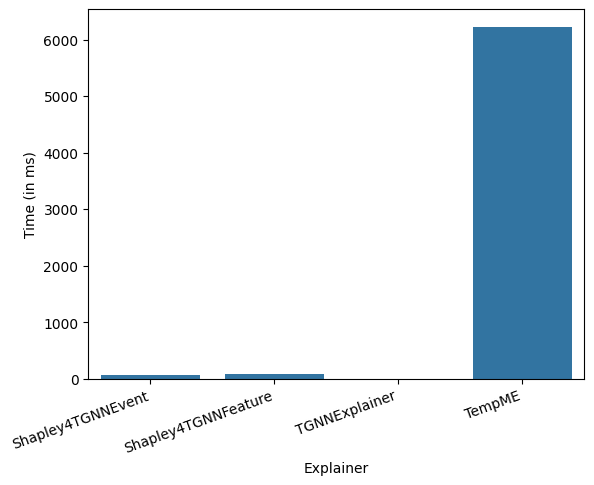

In [46]:
import matplotlib.pyplot as plt

p = sns.barplot(df_timings[df_timings.Action=="Init"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Wikipedia/Timings_init.png", bbox_inches='tight')

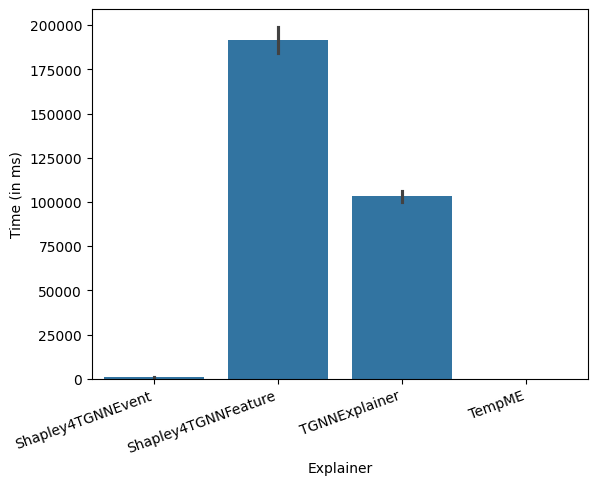

In [47]:
p = sns.barplot(df_timings[df_timings.Action=="Explain"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Wikipedia/Timings_expl.png", bbox_inches='tight')